In [8]:
# -*- coding: utf-8 -*-
"""GNN Model.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1pSO-VEyn5Cywjw9sXKn2fjXdVbI3hAsH
"""

# -*- coding: utf-8 -*-
"""Untitled2.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/193StgLnr4doKklAxwBiQsVX3njEfb1oa
"""


DATA_PATH = r"C:\Users\jamak\OneDrive\Thesis\Merged_Data.csv"

In [9]:
!pip install vmdpy
from vmdpy import VMD 

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime, timedelta
import warnings
import sys
sys.path.append('/kaggle/input/vmdpy')  # Adjust the path if needed

warnings.filterwarnings('ignore')


# Check for GPU and set device appropriately for Kaggle T4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set optimized CUDA options for T4 GPU
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False  # Better performance but less reproducible
    # Set to float16 precision for faster computation on T4 GPU
    torch.set_float32_matmul_precision('high')

# ============================================================
# MODIFIED DATA LOADING AND PROCESSING FOR TARGETED SEASONAL ANALYSIS
# ============================================================

def load_data(file_path):
    """
    Load weather data, clean missing values, and filter to San Jose only.
    """
    try:
        # Determine file type and read
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path, engine='openpyxl')
        else:
            df = pd.read_csv(file_path, encoding='ISO-8859-1')
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()  # Return empty DataFrame

    # Convert timestamp
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    elif 'DATE' in df.columns:
        df['timestamp'] = pd.to_datetime(df['DATE'])
        df = df.rename(columns={'DATE': 'date_original'})

    # Ensure time-based ordering before interpolation
    df = df.sort_values(by='timestamp')

    # Add hour of day feature - sine/cosine encoding for cyclical pattern
    df['hour_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.hour / 24)

    # Add day of year feature - sine/cosine encoding for cyclical pattern
    df['day_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.dayofyear / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.dayofyear / 365.25)

    # Define region mapping for LA Downtown only
    region_mapping = {
        'San Jose': 'urban'
    }

    # Filter to keep only LA Downtown
    if 'station_id' in df.columns:
        # Filter to LA Downtown only
        df = df[df['station_id'] == 'San Jose']
        
        # Add region information
        df['region'] = df['station_id'].map(region_mapping)

        # Convert region to numerical encoding
        region_to_num = {region: i for i, region in enumerate(df['region'].unique())}
        df['region_code'] = df['region'].map(region_to_num)

        # Add elevation for LA Downtown
        elevation_mapping = {
            'San Jose': 93         # meters
        }
        df['elevation'] = df['station_id'].map(elevation_mapping)
        # Normalize elevation (will be constant for single station)
        df['elevation_norm'] = 0.0  # Since we only have one station, just use 0 as normalized value

        print(f"Filtered data to San Jose only")

    # Interpolate missing values along the time dimension
    df.interpolate(method='linear', limit_direction='both', inplace=True)

    return df

# ============================================================
# VMD DECOMPOSITION
# ============================================================

import multiprocessing
import joblib
import os

def perform_vmd_decomposition(signal, alpha=2000, tau=0, K=10, DC=0, init=1, tol=1e-7):
    """
    Perform VMD decomposition on a signal.
    """
    # Run VMD
    u, u_hat, omega = VMD(signal, alpha, tau, K, DC, init, tol)
    
    # Calculate reconstruction residual
    recon = np.sum(u, axis=0)
    rres = np.sqrt(np.mean((signal - recon)**2)) / np.sqrt(np.mean(signal**2)) * 100
    
    return u, rres

def find_optimal_k(signal, k_range=range(6, 15)):
   """
   Find optimal K where rres < 3% with no sharp drop.
   """
   results = []
   
   print("Starting VMD mode selection process...")
   print(f"Target reconstruction error threshold: 3.0%")
   print("-" * 40)
   
   for k in k_range:
       print(f"Testing K={k}")
       _, rres = perform_vmd_decomposition(signal, K=k)
       results.append((k, rres))
       print(f"  K={k}, rres={rres:.2f}%")
       
       if rres < 3.0:
           print(f"✓ Found optimal K={k} with rres={rres:.2f}% (below 3.0% threshold)")
           print("-" * 40)
           return k, rres
   
   # If no K achieves rres < 3%, return the K with lowest rres
   best_k, best_rres = min(results, key=lambda x: x[1])
   print(f"! No K value achieved the target threshold.")
   print(f"✓ Selected best K={best_k} with lowest rres={best_rres:.2f}%")
   print("-" * 40)
   return best_k, best_rres

def decompose_station_data(data, feature_name, station_id, cache_dir='vmd_cache'):
    """
    Decompose time series data for a single station.
    """
    print(f"Starting decomposition for {station_id} - {feature_name}")
    
    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)
    
    # Create a unique cache filename
    cache_file = f"{cache_dir}/vmd_{station_id}_{feature_name}.joblib"
    
    # Check if cached results exist
    if os.path.exists(cache_file):
        print(f"Loading cached VMD decomposition for {station_id} - {feature_name}")
        return joblib.load(cache_file)
    
    # Get the time series to decompose
    print(f"  Extracting signal for {station_id}")
    signal = data[feature_name].values
    
    # Normalize signal
    print(f"  Normalizing signal")
    signal_norm = (signal - np.mean(signal)) / np.std(signal)
    
    # Find optimal K
    print(f"  Finding optimal K")
    k_opt, rres = find_optimal_k(signal_norm)
    print(f"Station {station_id}, feature {feature_name}: Optimal K={k_opt}, rres={rres:.2f}%")
    
    # Perform VMD with optimal K
    print(f"  Performing VMD with K={k_opt}")
    u, _ = perform_vmd_decomposition(signal_norm, K=k_opt)
    
    # Denormalize modes
    print(f"  Denormalizing modes")
    u_denorm = u * np.std(signal) + np.mean(signal) / k_opt
    
    # Save to cache
    print(f"  Saving to cache: {cache_file}")
    joblib.dump(u_denorm, cache_file)
    
    print(f"Completed decomposition for {station_id} - {feature_name}")
    return u_denorm

def parallel_vmd_decomposition(df, feature_cols_to_decompose=['Temperature_C'] ):
    """
    Apply VMD decomposition to multiple stations serially to avoid multiprocessing issues.
    """
    # Get the unique station IDs 
    station_ids = ['San Jose']  # We only have LA Downtown in this code
    
    decomposed_data = {}
    
    for feature in feature_cols_to_decompose:
        print(f"Performing VMD decomposition for feature: {feature}")
        
        # Process each station serially instead of in parallel
        results = []
        for station_id in station_ids:
            print(f"  Processing station: {station_id}")
            result = decompose_station_data(df, feature, station_id)
            results.append(result)
            
        # Store results
        for i, station_id in enumerate(station_ids):
            if station_id not in decomposed_data:
                decomposed_data[station_id] = {}
            decomposed_data[station_id][feature] = results[i]
    
    return decomposed_data

def extract_target_days(df):
    """
    Extract the 4 specific target days (one per season) for predictions
    """
    # Define target days
    target_days = [
        {'season': 'Spring', 'month': 4, 'day': 15},  # April 15
        {'season': 'Summer', 'month': 7, 'day': 20},  # July 20
        {'season': 'Fall', 'month': 10, 'day': 10},   # October 10
        {'season': 'Winter', 'month': 1, 'day': 15}   # January 15
    ]

    # Filter for each target day
    target_data = {}
    for target in target_days:
        # Filter by month and day
        day_data = df[(df['timestamp'].dt.month == target['month']) &
                       (df['timestamp'].dt.day == target['day'])]

        # Get the most recent year that has data for this day
        if not day_data.empty:
            latest_year = day_data['timestamp'].dt.year.max()
            target_day_data = day_data[day_data['timestamp'].dt.year == latest_year]
            target_data[target['season']] = target_day_data
            print(f"Found {len(target_day_data)} records for {target['season']} target day ({target['month']}/{target['day']}/{latest_year})")
        else:
            print(f"WARNING: No data found for {target['season']} target day")

    return target_data

def prepare_seasonal_training_data(df, target_days):
    """
    For each target day, prepare all historical data for training
    """
    training_sets = {}

    for season, target_day_data in target_days.items():
        if target_day_data.empty:
            continue

        # Get the date of this target
        sample_date = target_day_data['timestamp'].iloc[0]
        target_year = sample_date.year

        # Use all historical data prior to the target year
        historical_data = df[df['timestamp'].dt.year < target_year]

        training_sets[season] = historical_data
        print(f"{season} training set: {len(historical_data)} samples from all historical data")

    return training_sets

def split_data_temporal(df):
    """
    Custom temporal split:
    - Train: Jan 2021 – Dec 2022
    - Validation: Jan 2023 – Sep 2023
    - Test: Oct 2023 – Dec 2024
    """
    print("Custom temporal splitting...")

    train_df = df[(df['timestamp'] >= '2021-01-01') & (df['timestamp'] < '2023-01-01')]
    val_df = df[(df['timestamp'] >= '2023-01-01') & (df['timestamp'] < '2023-10-01')]
    test_df = df[df['timestamp'] >= '2023-10-01']

    print(f"Training: {len(train_df)} samples")
    print(f"Validation: {len(val_df)} samples")
    print(f"Testing: {len(test_df)} samples")

    return train_df, val_df, test_df


def normalize_features(train_df, val_df, feature_cols):
    """
    Normalize features using StandardScaler fitted on training data
    """
    scaler = StandardScaler()

    # Fit on training data
    scaler.fit(train_df[feature_cols])

    # Transform datasets
    train_scaled = scaler.transform(train_df[feature_cols])
    val_scaled = scaler.transform(val_df[feature_cols])

    # Convert back to DataFrames
    train_norm = pd.DataFrame(train_scaled, columns=feature_cols, index=train_df.index)
    val_norm = pd.DataFrame(val_scaled, columns=feature_cols, index=val_df.index)

    return train_norm, val_norm, scaler

class WeatherDataset(Dataset):
    """
    Dataset for weather forecasting with sliding window approach.
    Modified to work efficiently with single station San Jose.
    """
    def __init__(self, df, station_ids, feature_cols, seq_length=24, forecast_horizon=24):
        """
        Args:
            df: DataFrame with weather data (filtered to San Jose only)
            station_ids: List containing only 'San Jose'
            feature_cols: List of feature columns to use as input
            seq_length: Length of input sequence (in hours)
            forecast_horizon: How many hours ahead to predict
        """
        self.df = df
        self.station_ids = station_ids
        self.feature_cols = feature_cols
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        self.n_stations = len(station_ids)  # Should be 1

        # Get unique timestamps (now all from one station)
        self.timestamps = sorted(df['timestamp'].unique())

        # Filter valid timestamps (those that have enough history and future data)
        valid_idx = []
        for i in range(len(self.timestamps) - (seq_length + forecast_horizon - 1)):
            # Check if we have continuous data for this window
            current_time = self.timestamps[i]
            end_time = self.timestamps[i + seq_length + forecast_horizon - 1]
            expected_duration = timedelta(hours=seq_length + forecast_horizon - 1)

            if (end_time - current_time) == expected_duration:
                valid_idx.append(i)

        self.valid_indices = valid_idx

        # Add a safety check to ensure we have at least one valid window
        if len(self.valid_indices) == 0:
            print(f"WARNING: No valid windows found in dataset. Using reduced requirements.")
            # Fall back to allowing any windows where we have both input and output data
            valid_idx = []
            for i in range(len(self.timestamps) - seq_length):
                if i + seq_length < len(self.timestamps):
                    valid_idx.append(i)
            self.valid_indices = valid_idx
            self.fallback_mode = True
            print(f"Found {len(self.valid_indices)} windows with relaxed continuity requirements")
        else:
            self.fallback_mode = False
            print(f"Created dataset with {len(self.valid_indices)} valid windows")

    def __len__(self):
        return max(1, len(self.valid_indices))  # Ensure length is at least 1

    def __getitem__(self, idx):
        if len(self.valid_indices) == 0:
            # Return dummy data if no valid indices
            X = np.zeros((len(self.feature_cols), self.n_stations, self.seq_length))
            y = np.zeros((self.n_stations, self.forecast_horizon))
            static_features = np.zeros((self.n_stations, 2))  # region_code and elevation
            return (torch.FloatTensor(X), torch.FloatTensor(static_features)), torch.FloatTensor(y)

        # Get actual data when possible
        start_idx = self.valid_indices[idx % len(self.valid_indices)]

        # Get timestamps for input and output windows
        input_timestamps = self.timestamps[start_idx:start_idx + self.seq_length]
        output_timestamps = self.timestamps[start_idx + self.seq_length:
                                            start_idx + self.seq_length + self.forecast_horizon]

        # Handle potential shortfall in output window (fallback mode)
        if self.fallback_mode and len(output_timestamps) < self.forecast_horizon:
            # Pad with repetition of last timestamp if needed
            last_time = output_timestamps[-1] if len(output_timestamps) > 0 else input_timestamps[-1]
            padding = [last_time] * (self.forecast_horizon - len(output_timestamps))
            output_timestamps = list(output_timestamps) + padding

        # Initialize tensors - simpler now with just one station
        X = np.zeros((len(self.feature_cols), 1, self.seq_length))  # Only one station
        y = np.zeros((1, self.forecast_horizon))  # Only one station
        static_features = np.zeros((1, 2))  # region_code and elevation

        # LA Downtown is our only station
        station_id = 'San Jose'
        
        # Input sequence
        for t_idx, ts in enumerate(input_timestamps):
            station_data = self.df[self.df['timestamp'] == ts]

            if not station_data.empty:
                for f_idx, feat in enumerate(self.feature_cols):
                    X[f_idx, 0, t_idx] = station_data[feat].values[0]

                # Store static features (same for all timestamps)
                if t_idx == 0:
                    static_features[0, 0] = station_data['region_code'].values[0]
                    static_features[0, 1] = station_data['elevation_norm'].values[0]

        # Target sequence (temperature only)
        for t_idx, ts in enumerate(output_timestamps):
            if t_idx < self.forecast_horizon:  # Safety check
                station_data = self.df[self.df['timestamp'] == ts]

                if not station_data.empty:
                    y[0, t_idx] = station_data['Temperature_C'].values[0]

        return (torch.FloatTensor(X), torch.FloatTensor(static_features)), torch.FloatTensor(y)
# ============================================================
# TEMPORAL FUSION TRANSFORMER IMPLEMENTATION
# ============================================================
class TemporalSelfAttention(nn.Module):
    """
    Multi-head self-attention layer for temporal data.
    Simplified from the original TFT paper.
    """
    def __init__(self, d_model, n_heads=2, dropout=0.1):
        super(TemporalSelfAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        # Linear projections
        queries = self.query(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)
        keys = self.key(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)
        values = self.value(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        # Apply attention to values
        out = torch.matmul(attention, values)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

        # Final linear layer
        return self.out(out)

class GatedResidualNetwork(nn.Module):
    """
    Gated Residual Network as described in the TFT paper.
    Simplified version with fewer layers.
    """
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super(GatedResidualNetwork, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        # If input and output sizes are different, apply a skip connection
        self.skip_layer = None
        if input_size != output_size:
            self.skip_layer = nn.Linear(input_size, output_size)

        # Main layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.gate = nn.Linear(input_size + output_size, output_size)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(output_size)

    def forward(self, x):
        # Main branch
        hidden = F.elu(self.fc1(x))
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)

        # Skip connection
        if self.skip_layer is not None:
            skip = self.skip_layer(x)
        else:
            skip = x

        # Gate mechanism
        gate_input = torch.cat([x, hidden], dim=-1)
        gate = torch.sigmoid(self.gate(gate_input))

        # Combine using gate
        output = gate * hidden + (1 - gate) * skip

        # Layer normalization
        return self.layer_norm(output)

class VariableSelectionNetwork(nn.Module):
    """
    Variable Selection Network for TFT.
    Simplified version with fewer layers.
    """
    def __init__(self, input_size_per_var, num_vars, hidden_size, output_size, dropout=0.1):
        super(VariableSelectionNetwork, self).__init__()
        self.input_size_per_var = input_size_per_var
        self.num_vars = num_vars
        self.hidden_size = hidden_size
        self.output_size = output_size

        # GRN for variable weights
        self.weight_grn = GatedResidualNetwork(
            input_size=input_size_per_var * num_vars,
            hidden_size=hidden_size,
            output_size=num_vars,
            dropout=dropout
        )

        # GRN for each variable
        self.var_grns = nn.ModuleList([
            GatedResidualNetwork(
                input_size=input_size_per_var,
                hidden_size=hidden_size,
                output_size=output_size,
                dropout=dropout
            ) for _ in range(num_vars)
        ])

    def forward(self, x):
        # x shape: [batch_size, num_vars, input_size_per_var]
        batch_size = x.size(0)
        flat_x = x.view(batch_size, -1)

        # Calculate variable weights
        var_weights = self.weight_grn(flat_x)
        var_weights = F.softmax(var_weights, dim=-1).unsqueeze(-1)  # [batch_size, num_vars, 1]

        # Transform each variable
        var_outputs = []
        for i in range(self.num_vars):
            var_outputs.append(self.var_grns[i](x[:, i]))

        var_outputs = torch.stack(var_outputs, dim=1)  # [batch_size, num_vars, output_size]

        # Weighted combination
        outputs = torch.sum(var_outputs * var_weights, dim=1)  # [batch_size, output_size]

        return outputs, var_weights

class TemporalFusionTransformer(nn.Module):
    """
    Temporal Fusion Transformer with single predictions (no quantiles).
    Modified to expose variable importance weights.
    """
    def __init__(self, num_features, num_stations, hidden_size=64, num_heads=1, 
                 dropout=0.1, forecast_horizon=24, hidden_layers=2):
        super(TemporalFusionTransformer, self).__init__()
        self.num_features = num_features
        self.num_stations = num_stations
        self.hidden_size = hidden_size
        self.forecast_horizon = forecast_horizon
        self.hidden_layers = hidden_layers
        
        # Static variable processing
        self.static_var_processor = GatedResidualNetwork(
            input_size=2,  # region_code, elevation
            hidden_size=hidden_size,
            output_size=hidden_size,
            dropout=dropout
        )
        
        # Variable selection for time-varying features
        self.temporal_var_selection = VariableSelectionNetwork(
            input_size_per_var=24,  # Sequence length per feature
            num_vars=num_features,
            hidden_size=hidden_size,
            output_size=hidden_size,
            dropout=dropout
        )
        
        # LSTM encoder layers (same as before)
        self.lstm_layers = nn.ModuleList([
            # (Same LSTM configuration as before)
            nn.LSTM(
                input_size=hidden_size if i == 0 else hidden_size,
                hidden_size=hidden_size,
                batch_first=True
            ) for i in range(hidden_layers)
        ])
        
        # Temporal self-attention (same as before)
        self.self_attention = TemporalSelfAttention(
            d_model=hidden_size,
            n_heads=num_heads,
            dropout=dropout
        )
        
        # Final output layer for forecasting (same as before)
        self.forecast_projection = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, forecast_horizon)
        )
        
    def forward(self, inputs):
        # Unpack inputs
        temporal_features, static_features = inputs
        batch_size = temporal_features.size(0)
        
        # [batch, features, stations, time] -> [batch*stations, features, time]
        temporal_features = temporal_features.permute(0, 2, 1, 3)
        temporal_features = temporal_features.reshape(batch_size * self.num_stations, self.num_features, -1)
        
        # Static features: [batch, stations, static_dims] -> [batch*stations, static_dims]
        static_features = static_features.reshape(batch_size * self.num_stations, -1)
        
        # Process static features
        static_embeddings = self.static_var_processor(static_features)
        
        # Process temporal features with variable selection - STORE WEIGHTS
        temporal_embeddings, var_weights = self.temporal_var_selection(temporal_features)
        
        # Reshape to [batch*stations, seq_len, hidden]
        temporal_embeddings = temporal_embeddings.unsqueeze(1).expand(-1, 24, -1)
        
        # Add static embeddings to each timestep
        temporal_embeddings = temporal_embeddings + static_embeddings.unsqueeze(1)
        
        # Pass through LSTM layers
        lstm_out = temporal_embeddings
        for lstm_layer in self.lstm_layers:
            lstm_out, _ = lstm_layer(lstm_out)
        
        # Self-attention
        attention_out = self.self_attention(lstm_out)
        
        # Generate forecast
        forecast = self.forecast_projection(attention_out)
        
        # Take the last timesteps for the forecast horizon
        forecast = forecast[:, -self.forecast_horizon:, 0]
        
        # Reshape back to [batch, stations, horizon]
        forecast = forecast.reshape(batch_size, self.num_stations, -1)
        
        # Return both forecast and variable weights
        return forecast, var_weights

import random
from functools import partial



import torch
import numpy as np
import os
import time
from functools import partial
    
def train_model(model, train_loader, val_loader, learning_rate=0.001, epochs=30, patience=6, use_checkpoint=True, feature_names=None):
    """
    Train the model with MSE loss and early stopping. Now collects variable importance weights.
    """
    model.to(device)
    
    # (Same initialization code as before)
    checkpoint_path = 'checkpoint.pth'
    model_version = "single_output_v1"
    start_epoch = 0
    best_val_loss = float('inf')
    patience_counter = 0
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # (Same checkpoint loading code as before)
    if os.path.exists(checkpoint_path) and use_checkpoint:
        try:
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
    
    scaler = torch.cuda.amp.GradScaler()

    train_losses = []
    val_losses = []
    
    # Add storage for variable weights
    var_weights_history = []

    print(f"Starting training for {epochs} epochs with patience {patience}...")
    total_start_time = time.time()

    for epoch in range(start_epoch, epochs):
        # Training
        model.train()
        train_loss = 0
        train_batches = 0
        epoch_var_weights = []

        for inputs, targets in train_loader:
            # Move to device
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            elif isinstance(inputs, list):
                inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
            else:
                inputs = inputs.to(device)

            targets = targets.to(device)

            # Forward pass with mixed precision
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                outputs, var_weights = model(inputs)  # Now gets weights too
                loss = F.mse_loss(outputs, targets)

                # Collect variable weights (average across batch)
                avg_weights = var_weights.mean(dim=0).detach().cpu().numpy()
                epoch_var_weights.append(avg_weights)


            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            train_batches += 1
            
        avg_train_loss = train_loss / max(1, train_batches)
        train_losses.append(avg_train_loss)
        
        # Average variable weights across batches
        if epoch_var_weights:
            avg_epoch_weights = np.mean(epoch_var_weights, axis=0)
            var_weights_history.append(avg_epoch_weights)
            
            # Visualize variable importance every 5 epochs
            if epoch % 5 == 0 and feature_names is not None:
                visualize_variable_importance(avg_epoch_weights.squeeze(), feature_names, f"Epoch {epoch+1}")
        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                # Move to device
                if isinstance(inputs, tuple):
                    inputs = tuple(x.to(device) for x in inputs)
                elif isinstance(inputs, list):
                    inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
                else:
                    inputs = inputs.to(device)
                    
                targets = targets.to(device)

                # Forward pass
                outputs, _ = model(inputs)
                loss = F.mse_loss(outputs, targets)

                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / max(1, val_batches)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Learning rate scheduler
        scheduler.step(avg_val_loss)

        if use_checkpoint and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch,
                'model_version': model_version
            }, checkpoint_path)
            print(f"  Saved best model with val loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    np.save('variable_weights_history.npy', np.array(var_weights_history))            
    total_time = time.time() - total_start_time
    print(f"Training completed in {total_time/60:.2f} minutes")
    
    # Load best model
    if use_checkpoint and os.path.exists(checkpoint_path):
        try:
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded best model")
        except Exception as e:
            print(f"Error loading best model: {e}")

    return model, train_losses, val_losses, var_weights_history

def evaluate_model(model, data_loader, station_ids, regions):
    """
    Evaluate the model and calculate metrics with robust dimension handling.
    """
    model.eval()
    all_predictions = []
    all_actuals = []
    all_var_weights = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move to device - handle ALL possible input types
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            elif isinstance(inputs, list):
                inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
            else:
                inputs = inputs.to(device)

            # Forward pass with mixed precision for evaluation
            with torch.cuda.amp.autocast():
                outputs, var_weights = model(inputs)

            preds = outputs.detach().cpu().numpy()
            targets_cpu = targets.numpy()
            
            # Append batch predictions, targets, and weights
            all_predictions.append(preds)
            all_actuals.append(targets_cpu)
            all_var_weights.append(var_weights.cpu().numpy())
            
            # Clear GPU cache periodically
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Process predictions in chunks to save memory
    rmse_sum = 0
    mae_sum = 0
    r2_sum = 0
    sample_count = 0
    
    # Process in smaller chunks
    for preds, acts in zip(all_predictions, all_actuals):
        # Flatten current batch
        preds_flat = preds.flatten()  
        acts_flat = acts.flatten()
        
        # Update metrics
        rmse_sum += np.sum((preds_flat - acts_flat) ** 2)
        mae_sum += np.sum(np.abs(preds_flat - acts_flat))
        sample_count += len(preds_flat)
    
    # Calculate final metrics
    rmse = np.sqrt(rmse_sum / sample_count)
    mae = mae_sum / sample_count
    
    # For R², we need all data (this is an approximation)
    all_preds_concat = np.concatenate([p.flatten() for p in all_predictions])
    all_acts_concat = np.concatenate([a.flatten() for a in all_actuals])
    r2 = r2_score(all_acts_concat, all_preds_concat)

    print(f"Overall Metrics - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Since we only have one station San Jose, simplify the station metrics
    station_metrics = {
        station_ids[0]: {
            'region': regions.get(station_ids[0], 'Unknown'),
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
    }
    
    if all_var_weights and feature_names:
        avg_var_weights = np.mean([np.mean(w, axis=0) for w in all_var_weights], axis=0)
        visualize_variable_importance(avg_var_weights.squeeze(), feature_names, "Test Set")
    print(f"Station {station_ids[0]} ({regions.get(station_ids[0], 'Unknown')}) - "
          f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    return rmse, mae, r2, station_metrics

def visualize_predictions(model, data_loader, station_ids, regions, season):
    """
    Visualize predictions for each station.
    """
    model.eval()
    if len(data_loader) == 0:
        print("No data available for visualization")
        return
    
    # Get predictions
    try:
        for inputs, targets in data_loader:
            # Only process one batch for visualization
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            else:
                inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Move to CPU for plotting
            outputs = outputs.cpu().numpy()
            targets = targets.numpy()
            break

        # Check if we have data to plot
        if 'outputs' not in locals():
            print("No data was loaded from the dataloader")
            return
    except Exception as e:
        print(f"Error processing visualization data: {e}")
        return
    
    # Create subplots for each station
    fig, axes = plt.subplots(len(station_ids), 1, figsize=(12, 3*len(station_ids)))
    if len(station_ids) == 1:
        axes = [axes]

    hours = np.arange(24)

    for i, station in enumerate(station_ids):
        ax = axes[i]

        # Plot actual vs predicted
        ax.plot(hours, targets[0, i, :], 'b-', label='Actual')
        ax.plot(hours, outputs[0, i, :], 'r--', label='Predicted')

        ax.set_title(f"{station} ({regions.get(station, 'Unknown')}) - {season}")
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{season}_predictions.png")
    plt.show()  # Add this line to display the plot
    plt.close()

def predict_day_temperatures(model, day_data, feature_cols):
    """
    Predict temperatures for a single day (24 hours).
    
    Args:
        model: Trained TFT model
        day_data: DataFrame with data for the target day
        feature_cols: List of feature columns used by the model
        
    Returns:
        Predicted temperatures for 24 hours
    """
    model.eval()
    
    # Prepare input data format (same as in create_seasonal_datasets)
    try:
        # Format data for model input
        temporal_data = np.zeros((1, len(feature_cols), 1, 24))  # [batch=1, features, stations=1, time=24]
        
        # Fill temporal features
        for f_idx, feat in enumerate(feature_cols):
            if feat in day_data.columns:
                temporal_data[0, f_idx, 0, :] = day_data[feat].values[:24]
        
        # Create static features
        static_data = np.zeros((1, 1, 2))  # [batch=1, stations=1, static_features=2]
        static_data[0, 0, 0] = day_data['region_code'].iloc[0] 
        static_data[0, 0, 1] = day_data['elevation_norm'].iloc[0]
        
        # Convert to tensors
        X_temporal = torch.FloatTensor(temporal_data).to(device)
        X_static = torch.FloatTensor(static_data).to(device)
        
        # Make prediction
        with torch.no_grad():
            prediction, var_weights = model((X_temporal, X_static))
            
            # Visualize variable importance for this prediction
            weights = var_weights.squeeze().cpu().numpy()
            date_str = day_data['timestamp'].iloc[0].strftime('%Y-%m-%d')
            visualize_variable_importance(weights, feature_cols, f"Prediction {date_str}")
            
        # Return prediction as numpy array
        return prediction.cpu().numpy()[0, 0, :], weights
        
    except Exception as e:
        print(f"Error predicting temperatures: {e}")
        import traceback
        traceback.print_exc()
        return None
    
def plot_temperature_prediction(actual, predicted, date_str=None):
    """
    Plot actual vs predicted temperatures.
    
    Args:
        actual: Numpy array of actual temperatures (24 hours)
        predicted: Numpy array of predicted temperatures (24 hours)
        date_str: String representation of the date
    """
    hours = np.arange(24)
    
    plt.figure(figsize=(12, 6))
    plt.plot(hours, actual, 'b-o', label='Actual Temperature', linewidth=2)
    plt.plot(hours, predicted, 'r-o', label='Predicted Temperature', linewidth=2)
    
    title = f"Daily Temperature Forecast" 
    if date_str:
        title += f" for {date_str}"
    
    plt.title(title, fontsize=16)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Temperature (°C)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(hours)
    
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    filename = f"temperature_forecast_{date_str.replace(' ', '_').replace(':', '-')}.png" if date_str else "temperature_forecast.png"
    plt.show()

def create_mirror_plot(model, data_loader, station_ids, regions, season):
    """
    Create a mirror plot with actual temperature on left side and predicted on right side.
    """
    model.eval()
    if len(data_loader) == 0:
        print(f"No data available for {season} mirror plot")
        return
    
    # Get predictions
    try:
        for inputs, targets in data_loader:
            # Move inputs to device - handle ALL possible input types
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            elif isinstance(inputs, list):
                inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
            else:
                inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Move to CPU for plotting
            outputs = outputs.cpu().numpy()
            targets = targets.numpy()
            break
            
        if 'outputs' not in locals():
            print(f"No data was loaded for {season} mirror plot")
            return
    except Exception as e:
        print(f"Error processing mirror plot data for {season}: {e}")
        import traceback
        traceback.print_exc()  # Print full error details
        return
    
    # Create a figure for each station
    for i, station in enumerate(station_ids):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        
        hours = np.arange(24)
        
        # Left plot - Actual temperatures
        ax1.plot(hours, targets[0, i, :], 'b-o', linewidth=2)
        ax1.set_title(f"Actual Temperature - {season}", fontsize=14)
        ax1.set_xlabel('Hour of Day', fontsize=12)
        ax1.set_ylabel('Temperature (°C)', fontsize=12)
        ax1.set_xlim(0, 23)
        ax1.grid(True, alpha=0.3)
        ax1.invert_xaxis()  # Invert x-axis for mirror effect
        
        # Right plot - Predicted temperatures
        ax2.plot(hours, outputs[0, i, :], 'r-o', linewidth=2)
        ax2.set_title(f"Predicted Temperature - {season}", fontsize=14)
        ax2.set_xlabel('Hour of Day', fontsize=12)
        ax2.set_xlim(0, 23)
        ax2.grid(True, alpha=0.3)
        
        # Add overall title
        plt.suptitle(f"{station} ({regions.get(station, 'Unknown')}) - {season} Day Comparison", 
                    fontsize=16, y=1.05)
        
        # Add a line in the middle
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.05)  # Reduce space between subplots
        
        # Save and display
        plt.savefig(f"{season}_mirror_comparison.png", bbox_inches='tight')
        plt.show()
        plt.close()

def create_seasonal_datasets(df, target_days, all_stations, feature_cols):
    """
    Create datasets for each seasonal day and visualize predictions.
    """
    seasonal_datasets = {}
    
    for season, day_data in target_days.items():
        if day_data.empty:
            print(f"No data available for {season}")
            continue
            
        # Get the date of this target day
        sample_date = day_data['timestamp'].iloc[0]
        print(f"Creating dataset for {season}: {sample_date.strftime('%Y-%m-%d')}")
        
        try:
            # Prepare the data in the format expected by the model
            # Format should be: temporal_features [batch, features, stations, time], static_features [batch, stations, static_features]
            
            # Reshape features to match expected format
            temporal_data = np.zeros((1, len(feature_cols), 1, 24))  # [batch=1, features, stations=1, time=24]
            
            # Fill in the temporal features
            for f_idx, feat in enumerate(feature_cols):
                if feat in day_data.columns:
                    temporal_data[0, f_idx, 0, :] = day_data[feat].values[:24]  # Using first 24 records
            
            # Create static features (region_code and elevation)
            static_data = np.zeros((1, 1, 2))  # [batch=1, stations=1, static_features=2]
            static_data[0, 0, 0] = day_data['region_code'].iloc[0] 
            static_data[0, 0, 1] = day_data['elevation_norm'].iloc[0]
            
            # Create target (actual temperatures)
            target_data = np.zeros((1, 1, 24))  # [batch=1, stations=1, time=24]
            target_data[0, 0, :] = day_data['Temperature_C'].values[:24]  # Using first 24 records
            
            # Convert to tensors
            X_temporal = torch.FloatTensor(temporal_data)
            X_static = torch.FloatTensor(static_data)
            y = torch.FloatTensor(target_data)
            
            # Store as a list containing a single data point
            seasonal_datasets[season] = [((X_temporal, X_static), y)]
            print(f"Created {season} dataset with shapes: X_temporal={X_temporal.shape}, X_static={X_static.shape}, y={y.shape}")
            
        except Exception as e:
            print(f"Error creating {season} dataset: {e}")
            import traceback
            traceback.print_exc()
    
    return seasonal_datasets


def analyze_topographic_performance(station_metrics, regions):
    """
    Analyze model performance across different topographic regions.
    """
    # Group metrics by region
    region_metrics = {}
    for station, metrics in station_metrics.items():
        region = regions.get(station, 'Unknown')
        if region not in region_metrics:
            region_metrics[region] = []
        region_metrics[region].append(metrics)

    # Calculate average metrics by region
    region_avg_metrics = {}
    for region, metrics_list in region_metrics.items():
        avg_rmse = np.mean([m['rmse'] for m in metrics_list])
        avg_mae = np.mean([m['mae'] for m in metrics_list])
        avg_r2 = np.mean([m['r2'] for m in metrics_list])

        region_avg_metrics[region] = {
            'avg_rmse': avg_rmse,
            'avg_mae': avg_mae,
            'avg_r2': avg_r2
        }

        print(f"Region {region} - Avg RMSE: {avg_rmse:.4f}, Avg MAE: {avg_mae:.4f}, Avg R²: {avg_r2:.4f}")

        if not station_metrics:
            print("No station metrics available for analysis")
            return {}

    # Create bar chart comparing regions
    regions = list(region_avg_metrics.keys())
    rmse_values = [region_avg_metrics[r]['avg_rmse'] for r in regions]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(regions, rmse_values)

    # Add styling
    plt.title('RMSE by Topographic Region', fontsize=16)

    plt.title('RMSE by Topographic Region', fontsize=16)
    plt.ylabel('RMSE (°C)', fontsize=14)
    plt.xlabel('Region', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()
    plt.savefig('region_performance.png')
    plt.close()

    return region_avg_metrics

def analyze_seasonal_performance(seasonal_results):
    """
    Compare model performance across different seasons.
    """
    seasons = list(seasonal_results.keys())
    rmse_values = [results['rmse'] for results in seasonal_results.values()]
    mae_values = [results['mae'] for results in seasonal_results.values()]

    if not seasonal_results:
        print("No seasonal results available for analysis")
        return [], [], []

    # Create grouped bar chart
    x = np.arange(len(seasons))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, rmse_values, width, label='RMSE')
    ax.bar(x + width/2, mae_values, width, label='MAE')

    ax.set_title('Model Performance by Season', fontsize=16)
    ax.set_ylabel('Error (°C)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels
    for i, v in enumerate(rmse_values):
        ax.text(i - width/2, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

    for i, v in enumerate(mae_values):
        ax.text(i + width/2, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()
    plt.savefig('seasonal_performance.png')
    plt.close()

    return seasons, rmse_values, mae_values


def visualize_variable_importance(weights, feature_names, title_suffix=""):
    """
    Visualize the variable importance weights from the Variable Selection Network.
    
    Args:
        weights: Numpy array of variable weights [num_features]
        feature_names: List of feature names corresponding to the weights
        title_suffix: Additional text for the plot title
    """
    if len(weights) != len(feature_names):
        print(f"Warning: Number of weights ({len(weights)}) doesn't match feature names ({len(feature_names)})")
        feature_names = [f"Feature {i+1}" for i in range(len(weights))]
    
    # Sort features by importance
    sorted_indices = np.argsort(weights)
    sorted_weights = weights[sorted_indices]
    sorted_features = [feature_names[i] for i in sorted_indices]
    
    # Create horizontal bar chart
    plt.figure(figsize=(10, max(6, len(feature_names) * 0.4)))
    bars = plt.barh(range(len(sorted_weights)), sorted_weights, color='cornflowerblue')
    
    # Add styling
    plt.title(f'Variable Importance Weights {title_suffix}', fontsize=14)
    plt.xlabel('Weight', fontsize=12)
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.grid(True, linestyle='--', alpha=0.7, axis='x')
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.002, 
                 bar.get_y() + bar.get_height()/2, 
                 f'{width:.4f}',
                 va='center')
    
    plt.tight_layout()
    plt.show()

def visualize_importance_evolution(var_weights_history, feature_names):
    """
    Visualize how feature importance evolves during training.
    
    Args:
        var_weights_history: List of variable importance weights for each epoch
        feature_names: List of feature names
    """
    if not var_weights_history or not feature_names:
        print("No variable weights history or feature names available")
        return
    
    # Convert to numpy array
    weights_array = np.array(var_weights_history)
    if len(weights_array.shape) > 2:
        weights_array = weights_array.squeeze()
    
    # Plot evolution of weights over epochs
    plt.figure(figsize=(12, 8))
    epochs = range(1, len(weights_array) + 1)
    
    # Plot each feature's importance over time
    for i, feature in enumerate(feature_names):
        plt.plot(epochs, weights_array[:, i], '-o', label=feature, linewidth=2, markersize=3)
    
    plt.title('Evolution of Variable Importance During Training', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Importance Weight', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('variable_importance_evolution.png')
    plt.show()

Using device: cpu


Using device: cpu
Starting VMD-TFT temperature prediction pipeline...
Filtered data to San Jose only
Loaded data with 35040 records
Custom temporal splitting...
Training: 17496 samples
Validation: 6551 samples
Testing: 10993 samples
Performing VMD decomposition...
Performing VMD decomposition for feature: Temperature_C
  Processing station: San Jose
Starting decomposition for San Jose - Temperature_C
Loading cached VMD decomposition for San Jose - Temperature_C

==== VMD Modes Visualization ====


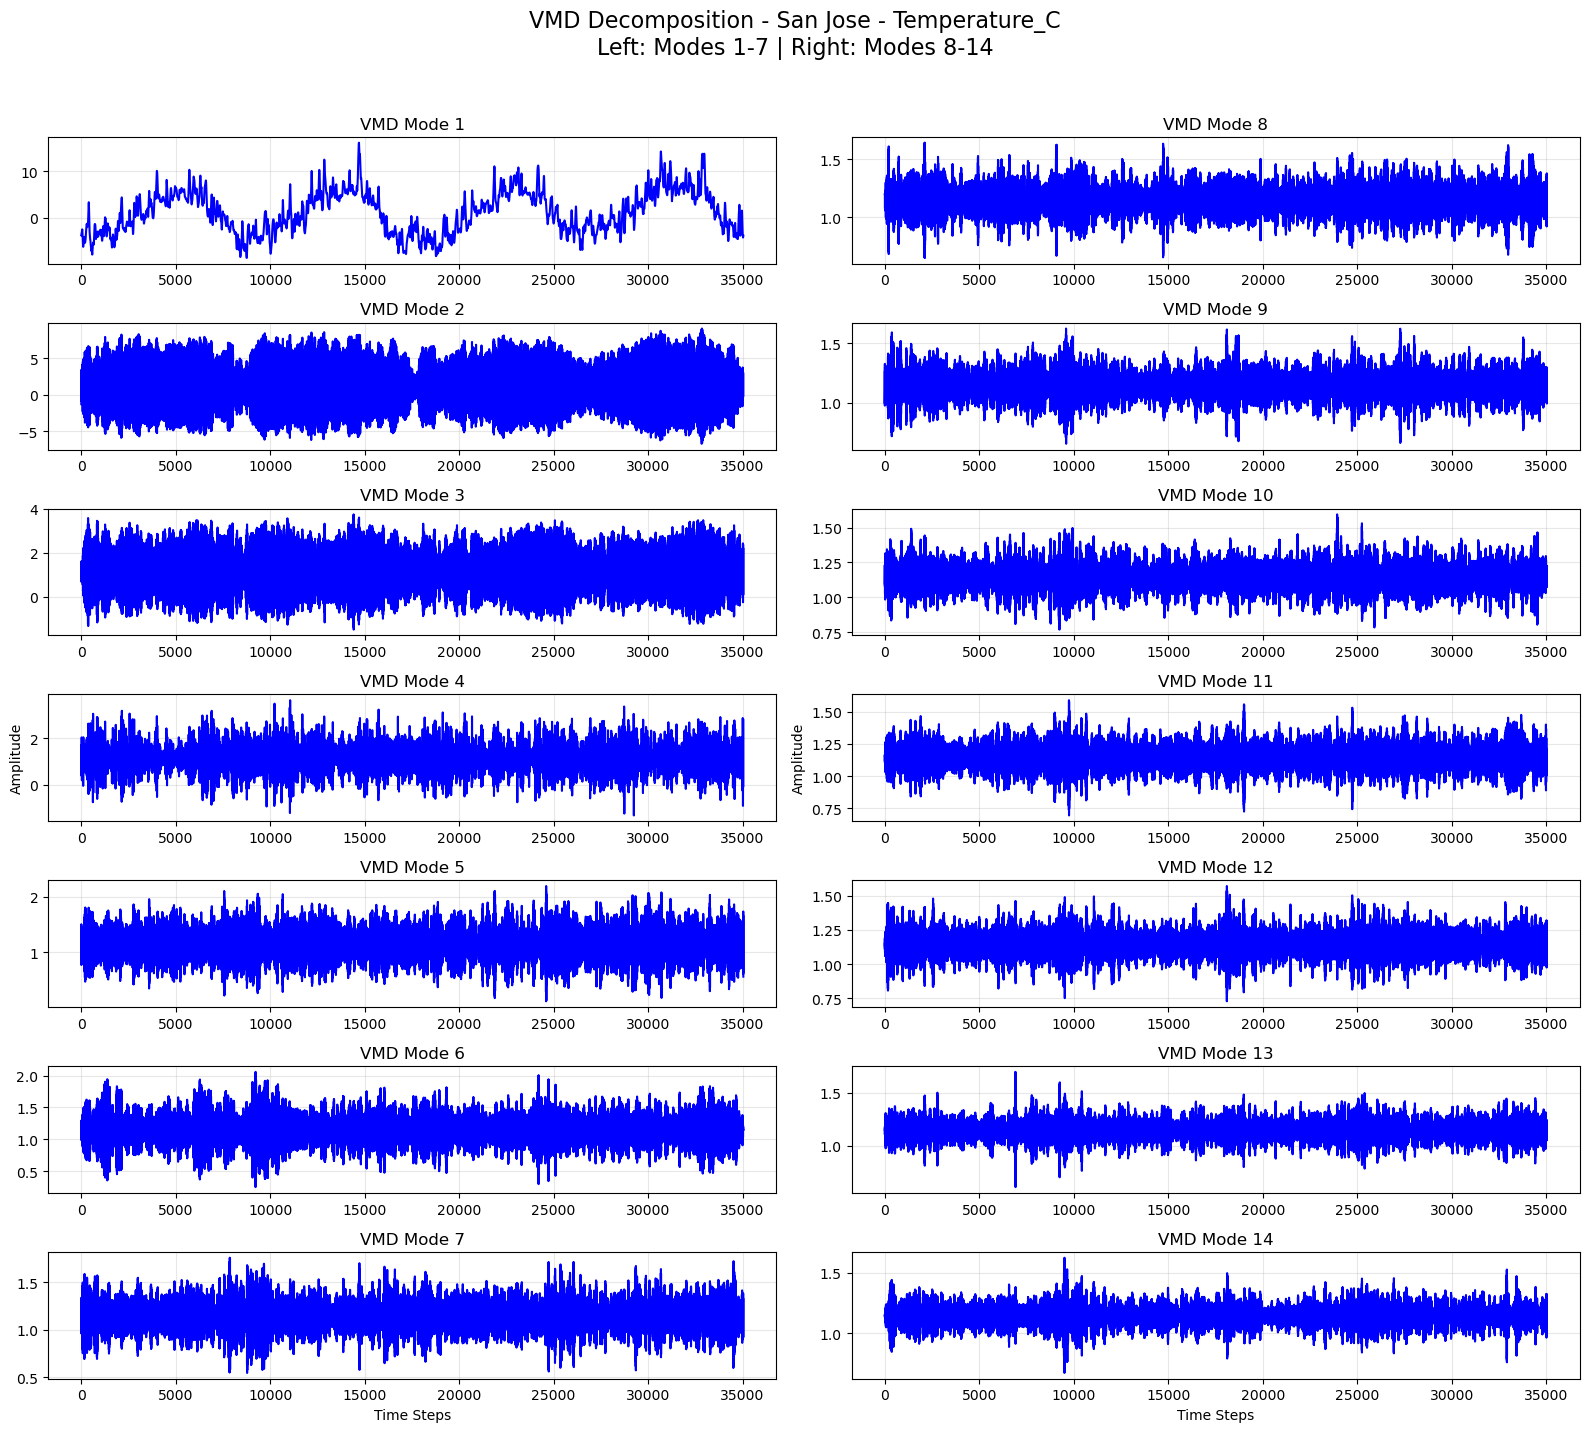


VMD Decomposition Summary for San Jose - Temperature_C:
Total number of modes: 14
Mode 1 - Energy: 748893.98
Mode 2 - Energy: 468275.55
Mode 3 - Energy: 81275.93
Mode 4 - Energy: 58870.77
Mode 5 - Energy: 48381.45
Mode 6 - Energy: 47577.14
Mode 7 - Energy: 46727.16
Mode 8 - Energy: 46426.00
Mode 9 - Energy: 46353.09
Mode 10 - Energy: 46279.69
Mode 11 - Energy: 46245.41
Mode 12 - Energy: 46231.26
Mode 13 - Energy: 46231.70
Mode 14 - Energy: 46216.98
==== End of VMD Visualization ====

Created dataset with 17449 valid windows
Created dataset with 6457 valid windows
Created dataset with 10946 valid windows
Resuming training from epoch 30
Starting training for 30 epochs with patience 20...
Training completed in 0.00 minutes
Loaded best model


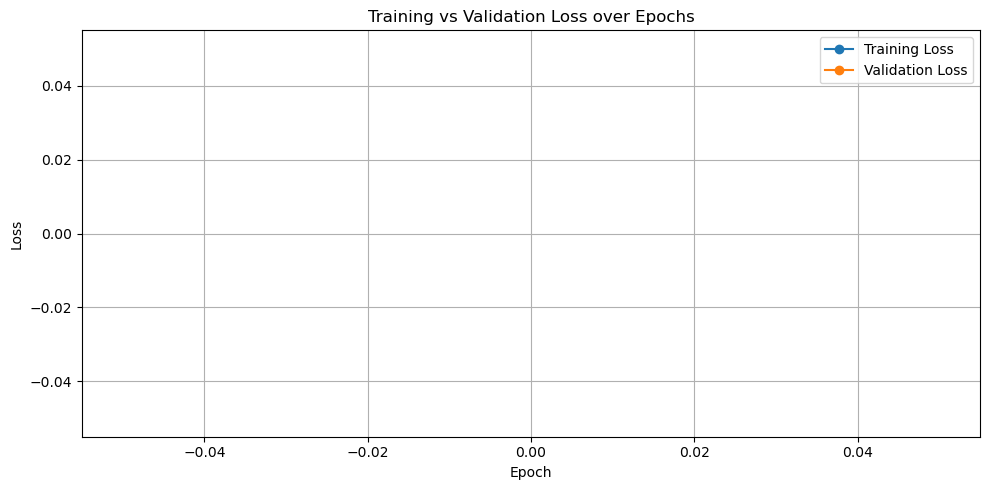

Overall Metrics - RMSE: 2.2645, MAE: 1.6824, R²: 0.8526


NameError: name 'feature_names' is not defined

In [11]:
def visualize_vmd_modes(decomposed_data, station_id='San Jose', feature='Temperature_C'):
    """
    Visualize ALL VMD decomposition modes split into two columns.
    Left column: First half of modes
    Right column: Second half of modes
    """
    if station_id not in decomposed_data or feature not in decomposed_data[station_id]:
        print(f"No VMD data available for station {station_id}, feature {feature}")
        return
    
    # Get the VMD modes
    modes = decomposed_data[station_id][feature]
    total_modes = modes.shape[0]
    
    # Split modes into two halves
    half_point = (total_modes + 1) // 2  # Handles odd numbers of modes
    modes_first_half = modes[:half_point, :]
    modes_second_half = modes[half_point:, :]
    
    # Create figure with two columns
    fig, axes = plt.subplots(max(len(modes_first_half), len(modes_second_half)), 2, 
                          figsize=(16, 2*max(len(modes_first_half), len(modes_second_half))))
    
    # If only one row, ensure axes is 2D array
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)
    
    # Plot first half in left column
    for i in range(len(modes_first_half)):
        ax = axes[i, 0]
        ax.plot(modes_first_half[i, :], 'b-')
        ax.set_title(f"VMD Mode {i+1}")
        ax.grid(True, alpha=0.3)
        if i == len(modes_first_half) // 2:
            ax.set_ylabel("Amplitude")
    
    # Plot second half in right column
    for i in range(len(modes_second_half)):
        ax = axes[i, 1]
        ax.plot(modes_second_half[i, :], 'b-')
        ax.set_title(f"VMD Mode {i+1+half_point}")
        ax.grid(True, alpha=0.3)
        if i == len(modes_second_half) // 2:
            ax.set_ylabel("Amplitude")
    
    # Hide empty subplots if odd number of modes
    if len(modes_first_half) > len(modes_second_half):
        axes[-1, 1].axis('off')
    
    # Add labels
    for ax in axes[-1, :]:
        ax.set_xlabel("Time Steps")
    
    plt.suptitle(f"VMD Decomposition - {station_id} - {feature}\nLeft: Modes 1-{half_point} | Right: Modes {half_point+1}-{total_modes}", 
                fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f"vmd_modes_split_{station_id}_{feature}.png")
    plt.show()
    
    # Print summary (unchanged from original)
    print(f"\nVMD Decomposition Summary for {station_id} - {feature}:")
    print(f"Total number of modes: {total_modes}")
    for i in range(total_modes):
        mode_energy = np.sum(modes[i, :]**2)
        print(f"Mode {i+1} - Energy: {mode_energy:.2f}")


def run_temperature_prediction(data_file, target_date=None):
    """
    Run the VMD-TFT temperature prediction pipeline.
    
    Args:
        data_file: Path to weather data file
        target_date: Optional datetime object for prediction target 
                     (if None, will use the latest available date in data)
    """
    print("Starting VMD-TFT temperature prediction pipeline...")
    
    df = load_data(data_file)
    print(f"Loaded data with {len(df)} records")
    if df.empty:
        print("Failed to load data. Exiting.")
        return
    
    # Split data by years
    train_df, val_df, test_df = split_data_temporal(df)
    
    # Define feature columns for the model
    feature_cols = [
    'Temperature_C',
    'HourlyRelativeHumidity',
    'HourlyStationPressure',
    'hour_sin', 'hour_cos',
    'day_sin', 'day_cos'
    ]
    
    # Perform VMD decomposition on temperature data
    print("Performing VMD decomposition...")
    decomposed_data = parallel_vmd_decomposition(df, feature_cols_to_decompose=['Temperature_C'])
    
    # Visualize VMD modes for Temperature_C
    print("\n==== VMD Modes Visualization ====")
    visualize_vmd_modes(decomposed_data, 'San Jose', 'Temperature_C')
    print("==== End of VMD Visualization ====\n")
    
    # Create datasets
    train_dataset = WeatherDataset(train_df, ['San Jose'], feature_cols, seq_length=24, forecast_horizon=24)
    val_dataset = WeatherDataset(val_df, ['San Jose'], feature_cols, seq_length=24, forecast_horizon=24)
    test_dataset = WeatherDataset(test_df, ['San Jose'], feature_cols, seq_length=24, forecast_horizon=24)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Create model
    model = TemporalFusionTransformer(
    num_features=len(feature_cols),
    num_stations=1,  # Just San Jose
    hidden_size=128,  # Increased from 64
    num_heads=2,     # Increased from 1
    dropout=0.1,
    forecast_horizon=24,
    hidden_layers=2
)

    model, train_losses, val_losses, var_weights_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=0.0003,
    epochs=30,
    patience=20,
    use_checkpoint=True,
    feature_names=feature_cols  # Added the feature names parameter
)
        # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.title("Training vs Validation Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    # Evaluate model
    rmse, mae, r2, station_metrics = evaluate_model(model, test_loader, ['San Jose'], {'San Jose': 'urban'})
    
    # Predict for target date
    if target_date is None:
        # Use last day in dataset
        target_date = df['timestamp'].max().date()
        print(f"No target date specified. Using last day in dataset: {target_date}")
    
    # Filter data for target day
    target_day_data = df[df['timestamp'].dt.date == target_date].copy()
    
    if target_day_data.empty:
        print(f"No data available for date {target_date}")
        return
        
    # Ensure we have 24 hours of data
    if len(target_day_data) < 24:
        print(f"Warning: Only {len(target_day_data)} hours available for {target_date}. Need 24 hours.")
        return
        
    # Make prediction
    print(f"Predicting temperatures for {target_date}...")
    predicted_temps = predict_day_temperatures(model, target_day_data, feature_cols)
    
    if predicted_temps is not None:
        # Get actual temperatures
        actual_temps = target_day_data['Temperature_C'].values[:24]
        
        # Plot results
        plot_temperature_prediction(actual_temps, predicted_temps, str(target_date))
        
        # Print prediction results
        print("\nPrediction Results:")
        print(f"{'Hour':<5} {'Actual':<10} {'Predicted':<10} {'Difference':<10}")
        print("-" * 40)
        for hour in range(24):
            diff = predicted_temps[hour] - actual_temps[hour]
            print(f"{hour:<5} {actual_temps[hour]:<10.2f} {predicted_temps[hour]:<10.2f} {diff:<10.2f}")
            
        # Calculate error metrics for this prediction
        day_mse = np.mean((predicted_temps - actual_temps) ** 2)
        day_rmse = np.sqrt(day_mse)
        day_mae = np.mean(np.abs(predicted_temps - actual_temps))
        
        print(f"\nDay prediction errors - RMSE: {day_rmse:.2f}°C, MAE: {day_mae:.2f}°C")


# Execute the pipeline when run as a script
if __name__ == "__main__":
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from torch.utils.data import Dataset, DataLoader
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from datetime import timedelta
    
    # Set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Import VMD implementation (assumed to be available)
    try:
        from vmdpy import VMD
    except ImportError:
        print("WARNING: VMD package not found. Please install vmdpy package for VMD decomposition.")
        
        # Define a simple stub for VMD function that returns random data for demo purposes
        def VMD(signal, alpha, tau, K, DC, init, tol):
            """Stub implementation of VMD for testing"""
            u = np.random.randn(K, len(signal))
            u_hat = np.random.randn(K, len(signal))
            omega = np.random.randn(K)
            return u, u_hat, omega
    
    c = r"C:\Users\jamak\OneDrive\Thesis\Merged_Data.csv"
    run_temperature_prediction(c, datetime(2024, 4, 15).date())

Starting VMD-TFT temperature prediction pipeline...
Filtered data to San Jose only
Loaded data with 35040 records
Custom temporal splitting...
Training: 17496 samples
Validation: 6551 samples
Testing: 10993 samples
Performing VMD decomposition...
Performing VMD decomposition for feature: Temperature_C
  Processing station: San Jose
Starting decomposition for San Jose - Temperature_C
Loading cached VMD decomposition for San Jose - Temperature_C

==== VMD Modes Visualization ====


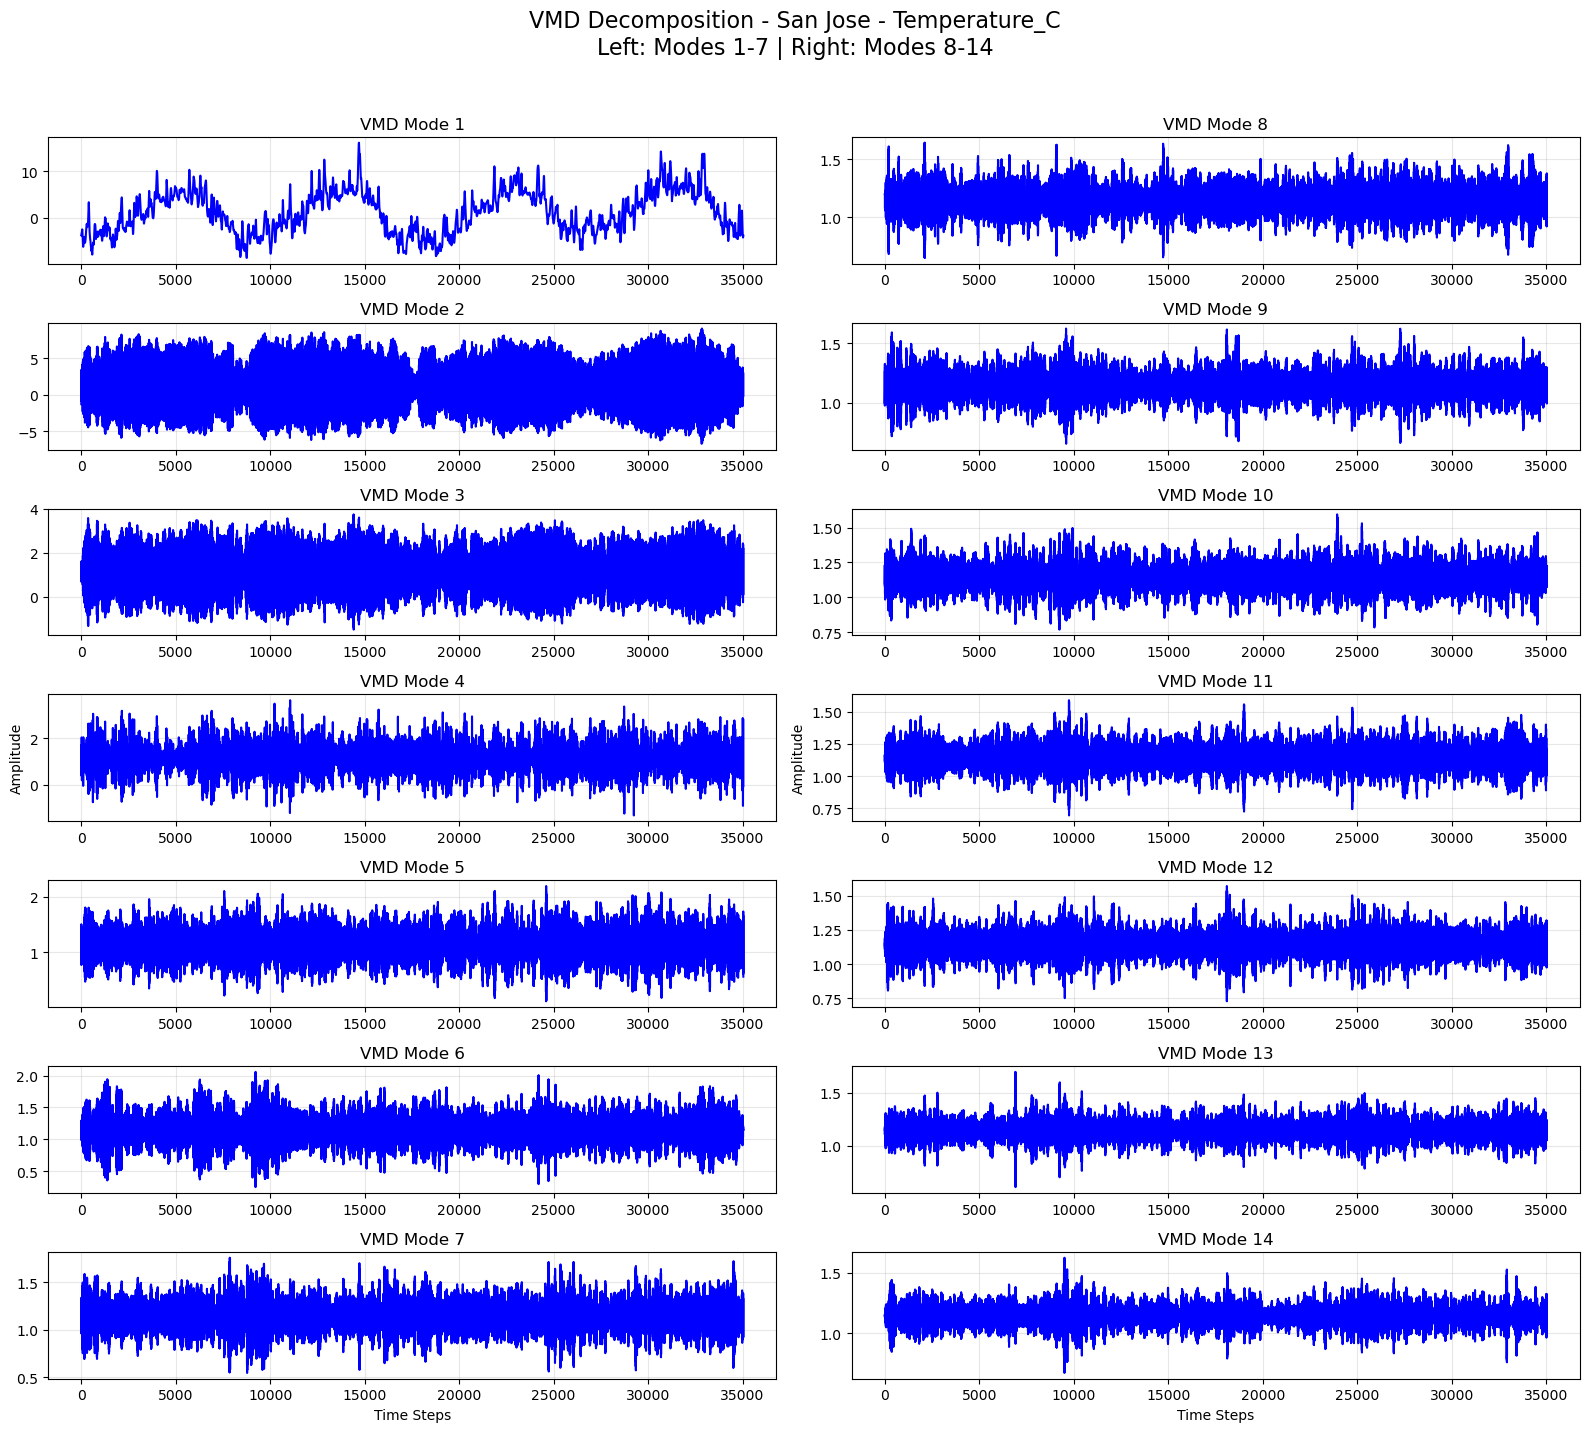


VMD Decomposition Summary for San Jose - Temperature_C:
Total number of modes: 14
Mode 1 - Energy: 748893.98
Mode 2 - Energy: 468275.55
Mode 3 - Energy: 81275.93
Mode 4 - Energy: 58870.77
Mode 5 - Energy: 48381.45
Mode 6 - Energy: 47577.14
Mode 7 - Energy: 46727.16
Mode 8 - Energy: 46426.00
Mode 9 - Energy: 46353.09
Mode 10 - Energy: 46279.69
Mode 11 - Energy: 46245.41
Mode 12 - Energy: 46231.26
Mode 13 - Energy: 46231.70
Mode 14 - Energy: 46216.98
==== End of VMD Visualization ====

Created dataset with 17449 valid windows
Created dataset with 6457 valid windows
Created dataset with 10946 valid windows
Resuming training from epoch 30
Starting training for 30 epochs with patience 20...
Training completed in 0.00 minutes
Loaded best model


ValueError: too many values to unpack (expected 3)

In [ ]:
c = r"C:\Users\jamak\OneDrive\Thesis\Merged_Data.csv"
run_temperature_prediction(c, datetime(2024, 1, 15).date())